In [1]:
%pylab inline
%matplotlib notebook

from scipy.sparse.linalg import spsolve
from scipy.sparse import spdiags, tril,diags

Populating the interactive namespace from numpy and matplotlib


# Iterative methods - Jacobi, Gauss-Seidel and Conjugate Gradient

Below are code that solve a linear system using the Jacobi, Gauss-Seidel and conjugate gradient methods.   You may use the results produced by this code to compare to your node-centered code.  

* In your MPI code, you are *not* to store the matrix $A$, or do any explicit matrix-vector multiplications.

* To parallize Gauss-Seidel, you will have to implement *Red-Black* ordering (not implemented here).

In [2]:
# Exact solution : u(x)
def u(x):
    u = cos(2*pi*x)
    return u

# u''(x)
def upp(x):
    upp = -(2*pi)**2*cos(2*pi*x)
    return upp

# RHS
def f(x):
    f = upp(x)
    return f

In [3]:
# General splitting method
def splitting(A,F,method,kmax,tol,prt):
    
    if method == 'jacobi':
        M = diags(A.diagonal(),format='csc')
    elif method == 'gs':
        M = tril(A,format='csc')  
        
    uk = zeros(F.shape)
    e = []
    for k in range(0,kmax):
        rk = F-A@uk
        zk = spsolve(M,rk)
        zk = reshape(zk,F.shape)    # not clear why zk doesn't have the correct shape!
        ukp1 = uk + zk
        e = e + [norm(zk,np.inf)]
        if prt:
            print("{:5d} {:12.4e}".format(k,e[k]))
        if e[k] < tol:
            break
            
        uk = ukp1
                    
    return ukp1,e
        

In [4]:
def dotv(u,v):
    return sum(u*v)

def cg(A,F,kmax,tol,prt):
    uk = zeros(F.shape)
    rk = F - A@uk
    pk = rk
    e = []
    for k in range(0,kmax):
        wk = A@pk
        alpha = dotv(rk,rk)/dotv(pk,wk)
        ukp1 = uk + alpha*pk
        rkp1 = rk - alpha*wk
        e = e + [norm(alpha*pk,np.inf)]
        if prt:           
            print("{:5d} {:12.4e}".format(k,e[k]))
            
        if e[k] < tol:
            break
            
        beta = dotv(rkp1,rkp1)/dotv(rk,rk)
        pk = rkp1 + beta*pk
        rk = rkp1
        uk = ukp1
        
    return ukp1,e

In [5]:
N = 128
xlong = linspace(0,1,N+1)
x = reshape(xlong[1:-1],(N-1,1))  # remove entries 0 and N+1; reshape vector.
h = 1.0/N
h2 = h**2

z = ones(N-1)
A = spdiags(vstack([z,-2*z,z]),[-1,0,1],N-1,N-1,format='csc')  # sparse storage
A = A/h2;
    
# Boundary conditions    
bc = zeros((N-1,1))    # "tuple" (N-1,1) describes shape of the array.
bc[0] = u(0)
bc[-1] = u(1)           # Use -1 to assign to last entry
    
F = f(x) - bc/h2

kmax = 100000
tol = 1e-10
prt = False

Ue = u(x)

print("Node-centered mesh (N = {:d};  tol = {:8.2e}; kmax = {:d})".format(N,tol,kmax))
print("")

def compute_error(U,Ue,h):
    err_method = abs(U-Ue)
    err = [0]*3
    err[0] = norm(err_method,1)*h
    err[1] = sqrt(norm(err_method,2)*h)
    err[2] = norm(err_method,np.inf)
    return err
        
results = '{:18s} {:6d} {:8d} {:12.4e} {:12.4e} {:12.4e} {:12.4e}'.format

# Jacobi
U,E_jacobi = splitting(A,F,'jacobi',kmax,tol,prt)
err_jacobi = compute_error(U,Ue,h)
print(results('Jacobi',N,len(E_jacobi),E_jacobi[-1],*err_jacobi))

# Gauss-Seidel
U,E_gs = splitting(A,F,'gs',kmax,tol,prt)
err_gs = compute_error(U,Ue,h)
print(results('Gauss-Seidel',N,len(E_gs),E_gs[-1],*err_gs))

# Conjugate Gradient
U,E_cg = cg(A,F,kmax,tol,prt)
err_cg = compute_error(U,Ue,h)
print(results('Conjugate Gradient',N,len(E_cg),E_cg[-1],*err_gs))

Node-centered mesh (N = 128;  tol = 1.00e-10; kmax = 100000)

Jacobi                128    51284   9.9984e-11   2.0077e-04   4.6620e-03   4.0156e-04
Gauss-Seidel          128    24492   9.9976e-11   2.0072e-04   4.6615e-03   4.0148e-04
Conjugate Gradient    128       65   4.1558e-16   2.0072e-04   4.6615e-03   4.0148e-04


<IPython.core.display.Javascript object>


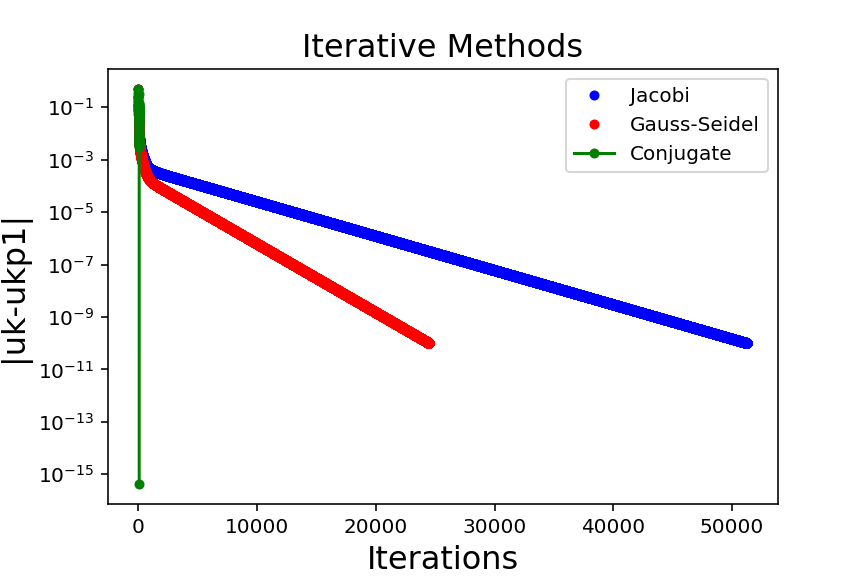

Text(0.5,1,'Iterative Methods')

In [6]:
figure()
semilogy(E_jacobi,'b.',markersize=8,label='Jacobi')
semilogy(E_gs,'r.',markersize=8,label='Gauss-Seidel')
semilogy(E_cg,'g.-',markersize=8,label='Conjugate')

legend()
xlabel('Iterations',fontsize=16)
ylabel('|uk-ukp1|',fontsize=16);
title('Iterative Methods',fontsize=16)